# Import Data

In [1]:
#load npy files
import numpy as np
import gc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
#load the data
augmented_no = np.load('../00_data/augumented/augmented_no.npy')
augmented_sphere = np.load('../00_data/augumented/augmented_sphere.npy')
augmented_vort = np.load('../00_data/augumented/augmented_vort.npy')


In [3]:
augmented_no.shape

(50000, 150, 150)

In [4]:
#make y classes for the data
y_no = np.zeros((augmented_no.shape[0],1))
y_sphere = np.ones((augmented_sphere.shape[0],1))
y_vort = np.full((augmented_vort.shape[0],1),2)

In [5]:
from tensorflow.keras.utils import to_categorical
y_no = to_categorical(y_no, num_classes=3)
y_sphere = to_categorical(y_sphere, num_classes=3)
y_vort = to_categorical(y_vort, num_classes=3)

2024-03-28 03:42:19.979748: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-28 03:42:20.017760: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 03:42:20.847433: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
#append the x data and y data

x_data = np.concatenate((augmented_no, augmented_sphere, augmented_vort), axis=0)
y_data = np.concatenate((y_no, y_sphere, y_vort), axis=0)


In [7]:
del(augmented_no, augmented_sphere, augmented_vort, y_no, y_sphere, y_vort)

gc.collect()

0

In [8]:
#convert x_data to float32 
x_data = x_data.astype('float32')

gc.collect()

0

In [9]:
x_data[0].max()

0.9765219

# Image Visualization

In [10]:
def apply_preprocessing(image, preprocessing_functions):
    """
    Apply a list of preprocessing functions to an image.
    
    Parameters:
    - image: The input image.
    - preprocessing_functions: A list of functions that take an image as input and return a processed image.
    
    Returns:
    - Processed image.
    """
    for function in preprocessing_functions:
        image = function(image)
    return image

def plot_image_grid(x_data,no_subhalo_indices, sphere_subhalo_indices, vort_subhalo_indices, preprocessing_functions=[]):
    fig, axes = plt.subplots(3, len(no_subhalo_indices), figsize=(len(no_subhalo_indices)*5, 5*3))
    for row, indices in enumerate([no_subhalo_indices, sphere_subhalo_indices, vort_subhalo_indices]):
        for i, idx in enumerate(indices):
            processed_image = apply_preprocessing(x_data[idx], preprocessing_functions)
            sns.heatmap(processed_image, ax=axes[row, i], cbar=False, cmap='inferno')
            if row == 0:
                axes[row, i].set_title(f"No Subhalo {idx}")
            elif row == 1:
                axes[row, i].set_title(f"Sphere Subhalo {idx}")
            else:
                axes[row, i].set_title(f"Vort Subhalo {idx}")
            axes[row, i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [37]:
base_no = np.array([0,8,62,35,46,235])*10
no_subhalo = base_no
sphere_subhalo = base_no +50000
vort_subhalo = base_no +100000

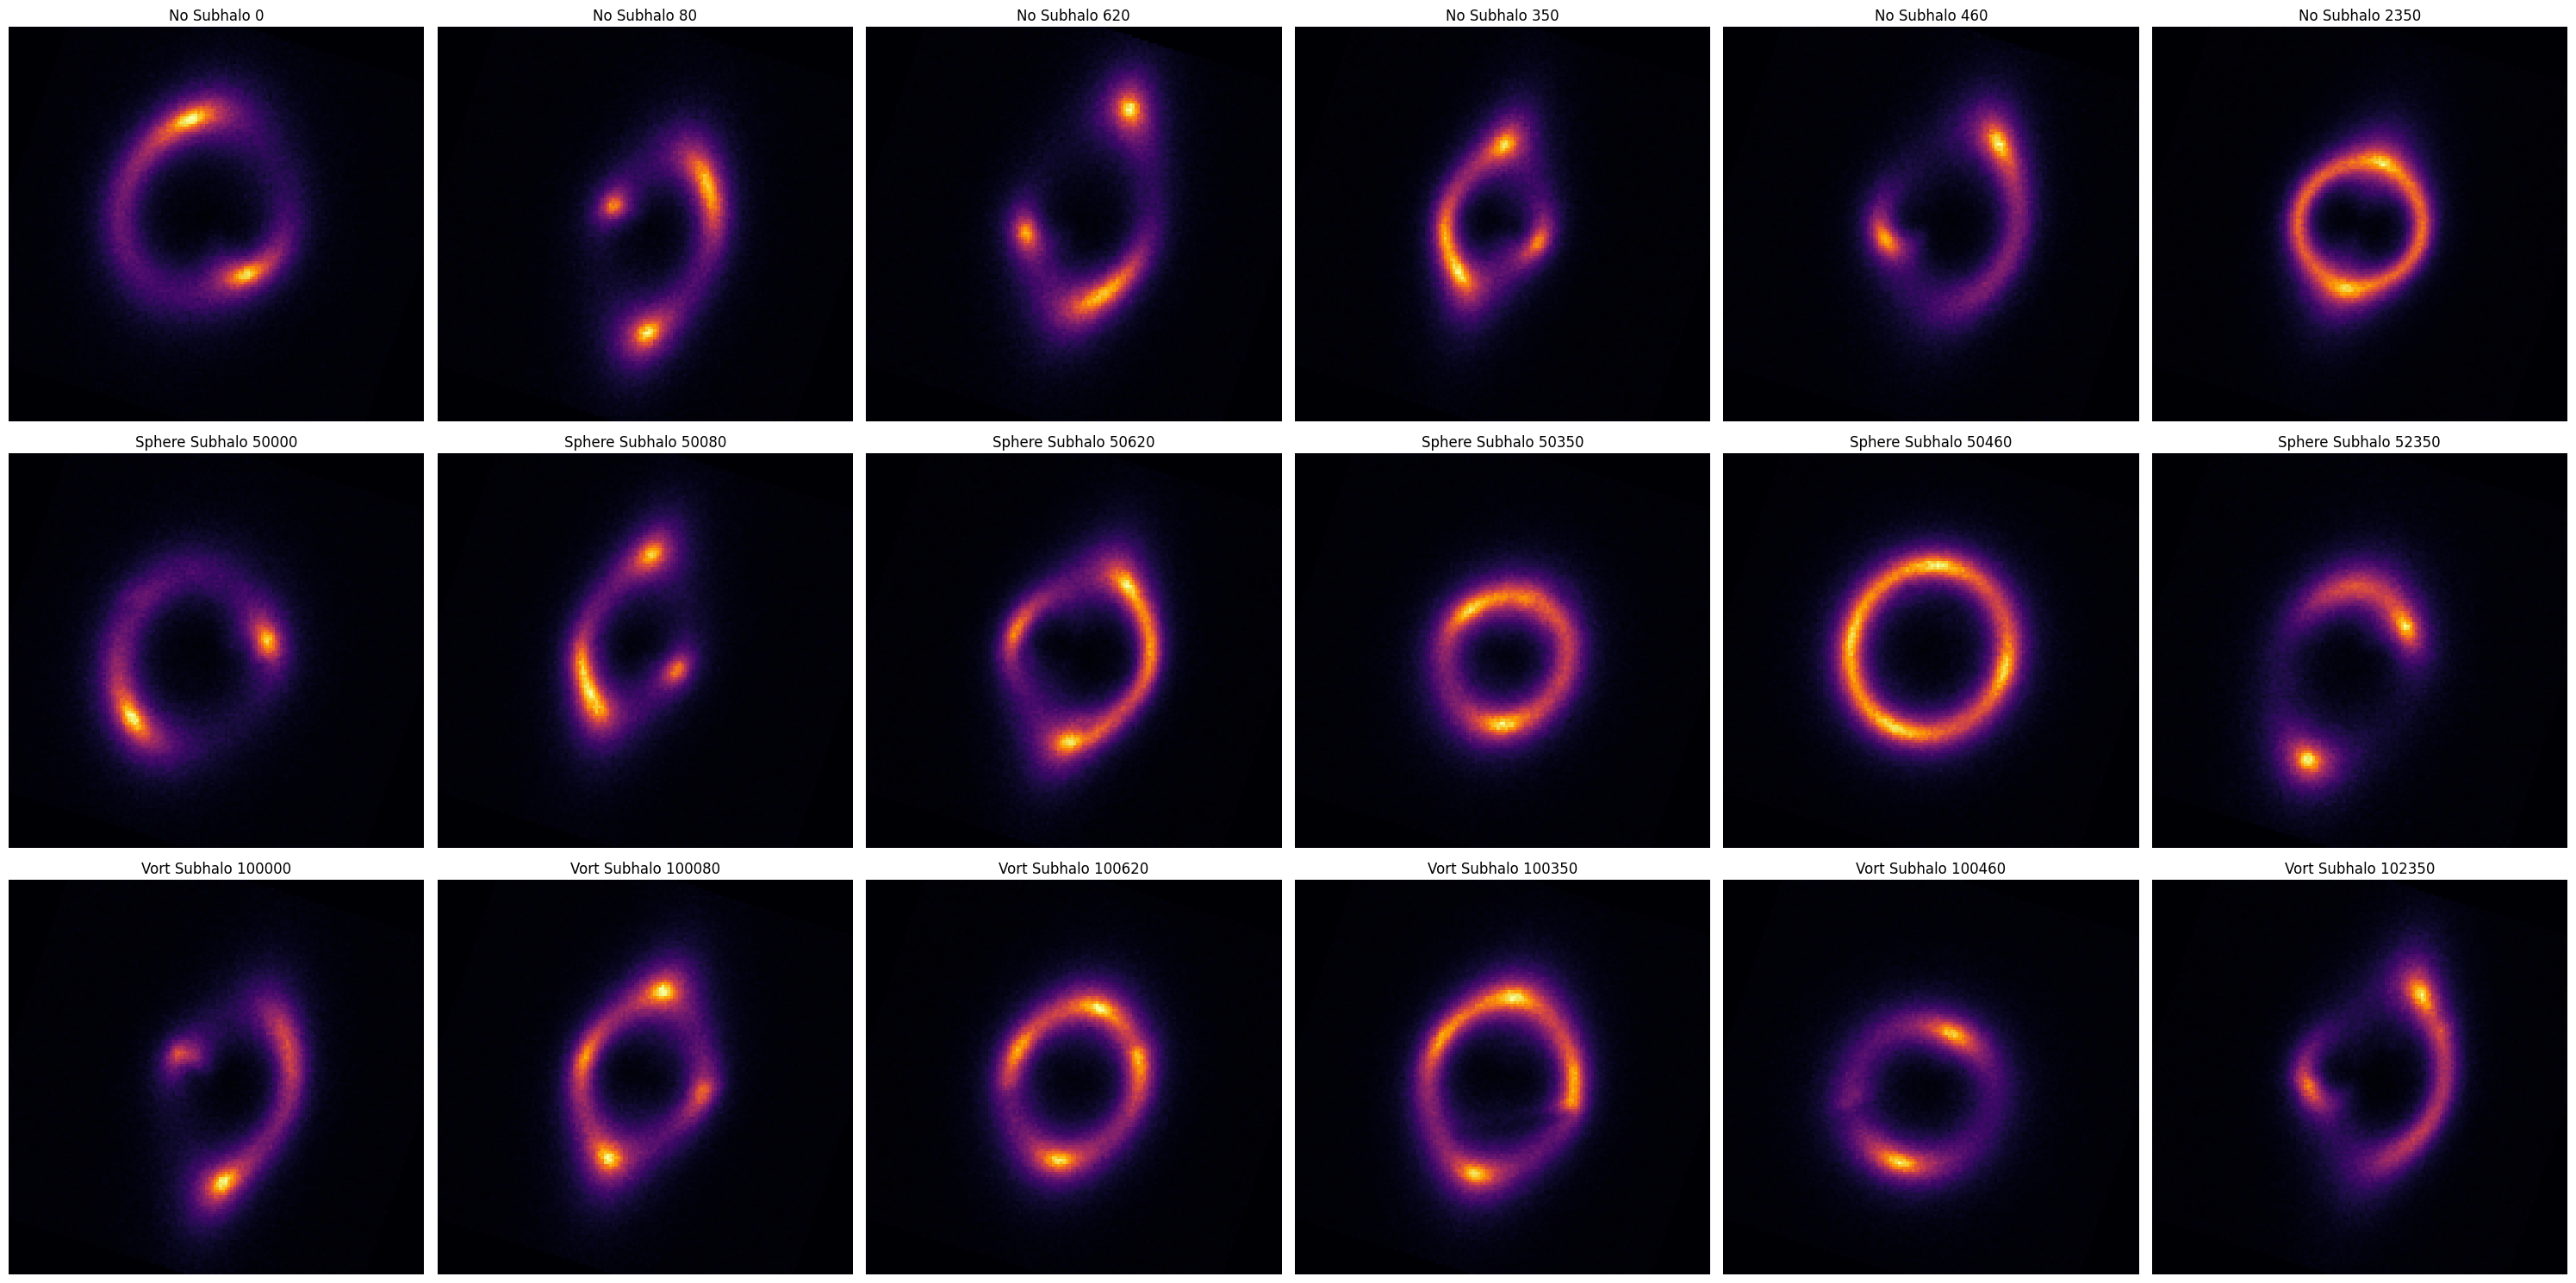

In [38]:
# Example usage
plot_image_grid(x_data,no_subhalo, sphere_subhalo, vort_subhalo)

In [83]:
import numpy as np
import cv2
from skimage import exposure, filters, feature, transform, draw
from skimage.transform import hough_circle, hough_circle_peaks


def thresholding( threshold=0.1):

    def inner_thresholding(image):
        # Apply thresholding to create a binary image
        binary_image = (image > threshold).astype(np.float32)
        return binary_image
    # Apply thresholding to create a binary image
    return inner_thresholding

def thresholding_image(threshold=0.1):
    
    def inner_thresholding(image):
        # Apply thresholding to create a binary image
        binary_image = (image > threshold).astype(np.float32)

        return image * binary_image
    
    return inner_thresholding

def histogram_normalization():
    
    def inner_histogram_normalization(image):
        # Equalize the image histogram
        image_norm = exposure.equalize_hist(image)
        return image_norm
    
    return inner_histogram_normalization

def erosion_dilation(erosion_iter=1, dilation_iter=1, kernel_size=(3,3)):
    
    def inner_erosion_dilation(image):
        # Generate the kernel for morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
        # Apply erosion and dilation
        image_eroded = cv2.erode(image, kernel, iterations=erosion_iter)
        image_dilated = cv2.dilate(image_eroded, kernel, iterations=dilation_iter)
        return image_dilated
    
    return inner_erosion_dilation

def gaussian_blur(kernel_size=(5,5), sigma=1):

    def inner_gaussian_blur(image):
        # Apply Gaussian Blur to the image
        image_blurred = cv2.GaussianBlur(image, kernel_size, sigma)
        return image_blurred
    return inner_gaussian_blur

def gabor_filter(frequency=0.6):
    # Apply Gabor filter to the image

    def inner_gabor_filter(image):
        filt_real, filt_imag = filters.gabor(image, frequency=frequency)
        filt_image = np.sqrt(filt_real**2 + filt_imag**2)
        return filt_image

    return inner_gabor_filter

def hough_circle_transform(radius_range):

    def inner_hough_circle_transform(image):
        # Detect circles using the Hough transform
        edges = feature.canny(image)
        hough_radii = np.arange(radius_range[0], radius_range[1], 1)
        hough_res = hough_circle(edges, hough_radii)
        accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
        return draw_circles(cx, cy, radii)(image)

    return inner_hough_circle_transform

def draw_circles(cx, cy, radii):

    def inner_draw_circles(image):
        # Draw circles on an empty canvas and add it to the original image
        canvas = np.zeros_like(image)
        for center_y, center_x, radius in zip(cy, cx, radii):
            rr, cc = draw.circle(center_y, center_x, radius, shape=image.shape)
            canvas[rr, cc] = 1

        return image + canvas
    
    return inner_draw_circles

def radial_gradient_filter(center=None):

    def inner_radial_gradient_filter(image):
        # Apply a radial gradient filter to the image
        center=None
        if center is None:
            center = (image.shape[1]//2, image.shape[0]//2)
        Y, X = np.ogrid[:image.shape[0], :image.shape[1]]
        gradient = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
        gradient = gradient / gradient.max()
        image_radial = image * gradient
        return image_radial

    return inner_radial_gradient_filter


def normalize_image():
    """
    Normalize the image so that the min value is 0 and the max value is 1.
    
    Parameters:
    - image: A 2D numpy array representing the image.
    
    Returns:
    - A normalized 2D numpy array with values between 0 and 1.
    """
    
    
    def inner_normalize_image(image):    
        min_val = np.min(image)
        max_val = np.max(image)
        # Avoid division by zero if the image is already flat
        if max_val - min_val == 0:
            return image
        else:
            normalized_image = (image - min_val) / (max_val - min_val)
            return normalized_image
    
    return inner_normalize_image

def add_minimum_to_image():
    """
    Add the minimum value of the image to all pixels.
    
    Parameters:
    - image: A 2D numpy array representing the image.
    
    Returns:
    - A 2D numpy array with the minimum value added to all pixels.
    """
    
    def inner_add_minimum_to_image(image):
        min_val = 0.00001
        image = image + min_val
        return image
    
    return inner_add_minimum_to_image


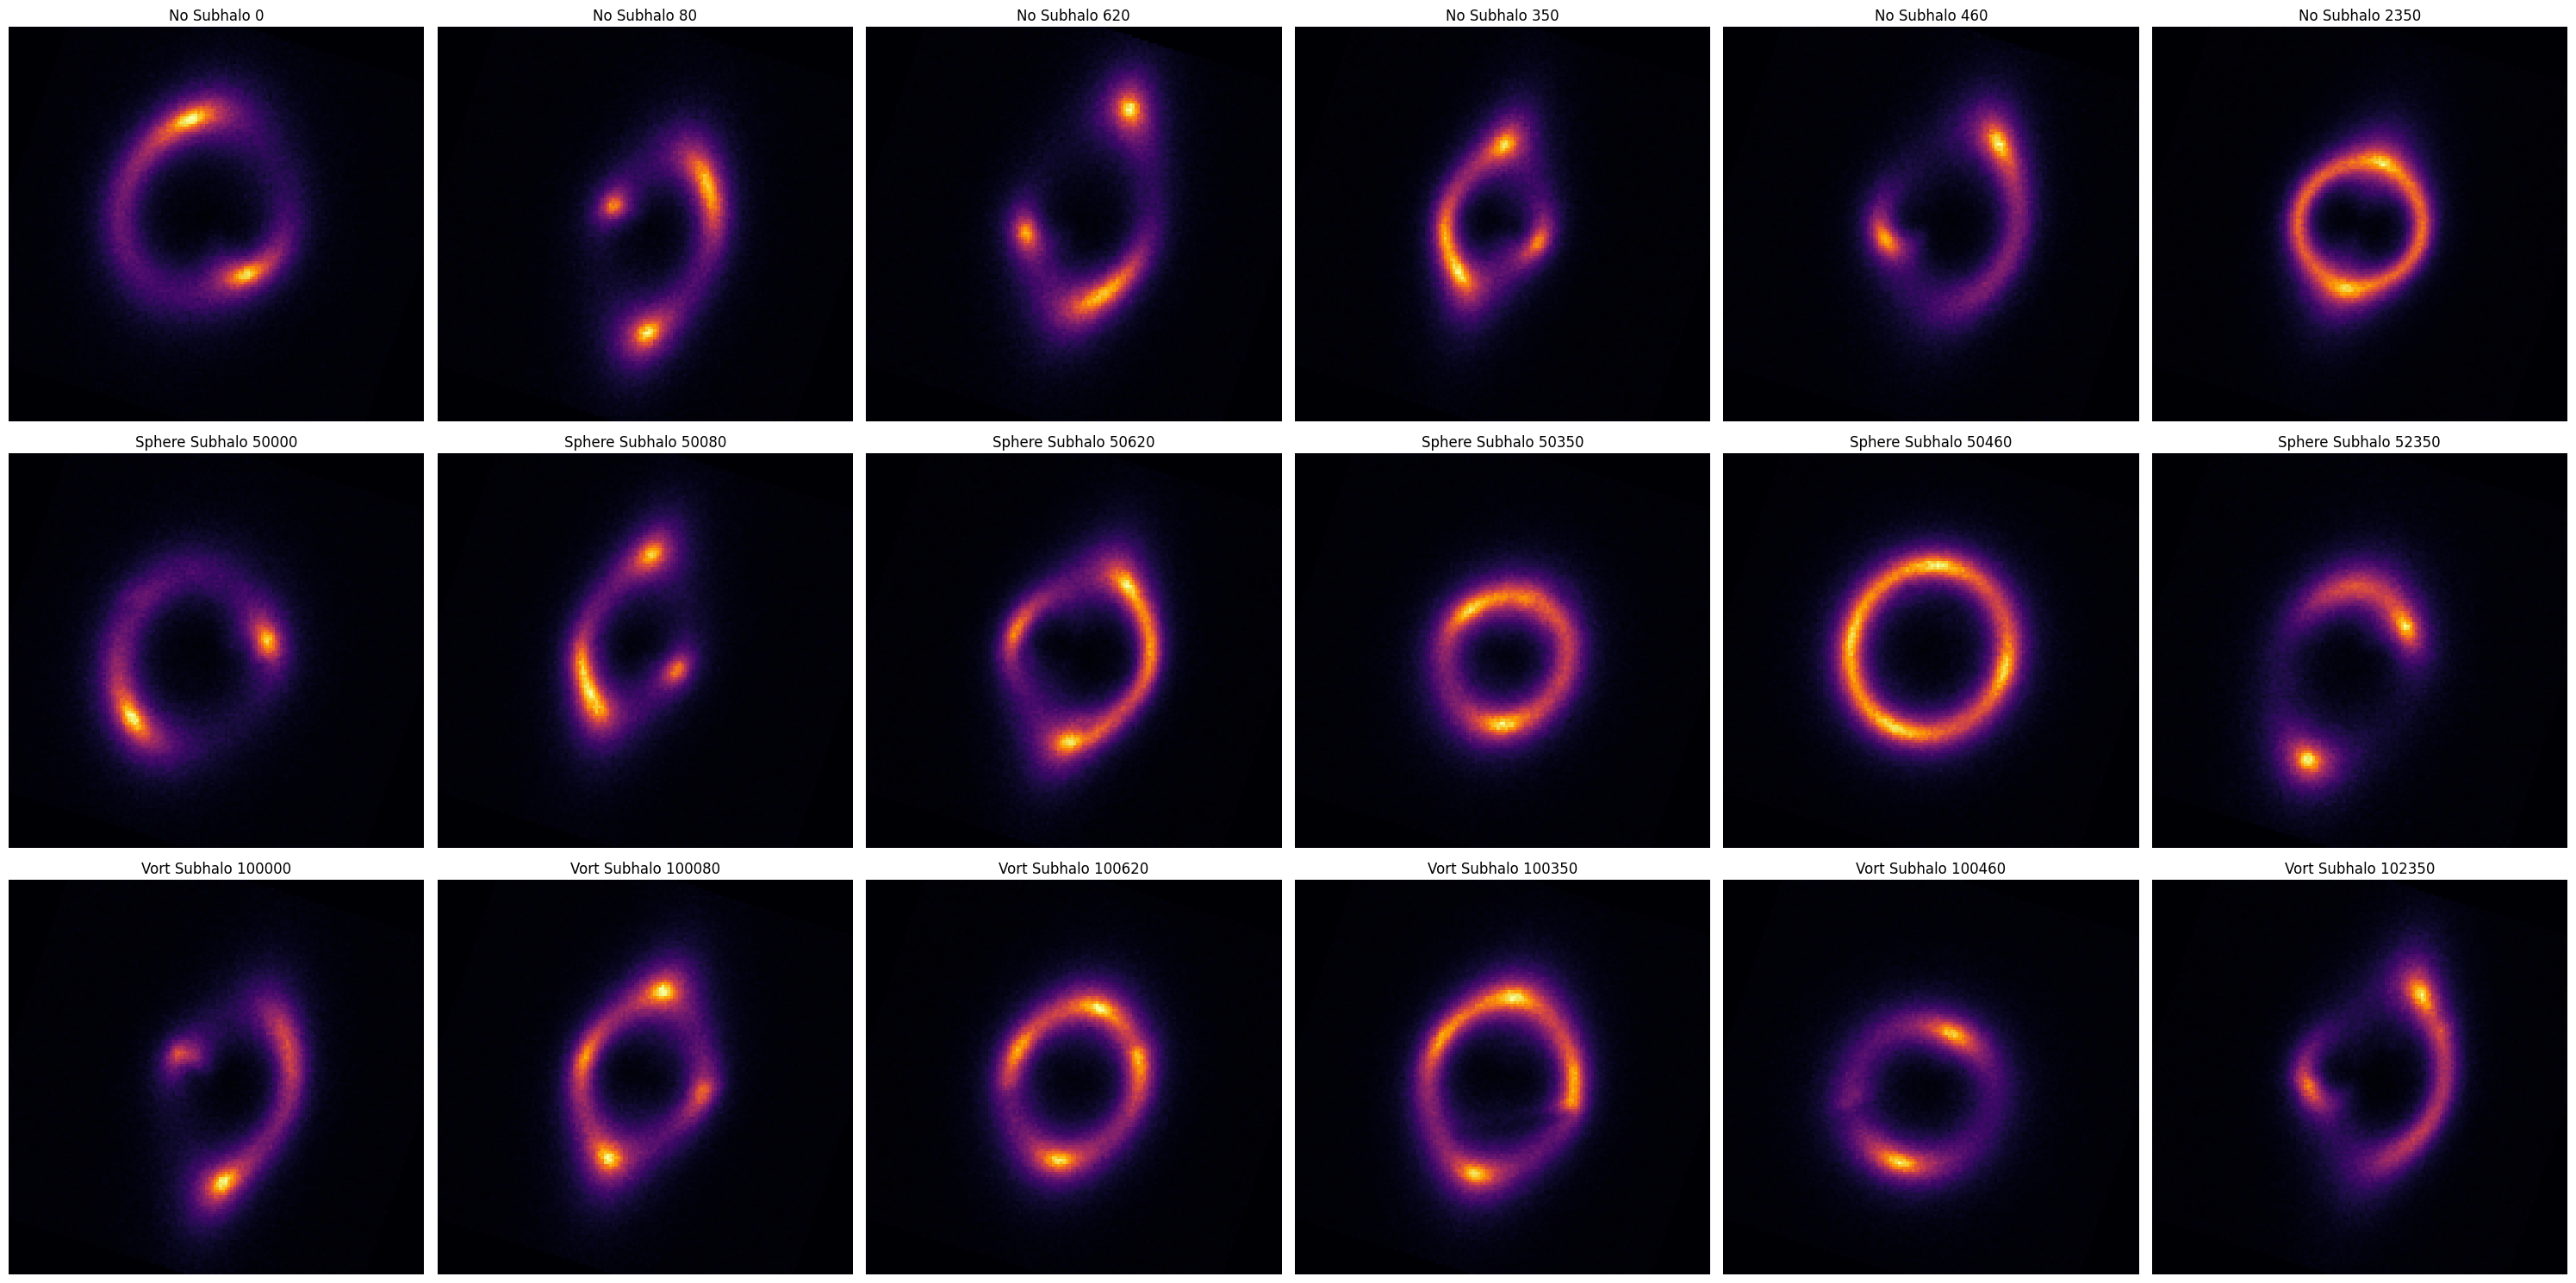

In [97]:
plot_image_grid(x_data, no_subhalo, sphere_subhalo, vort_subhalo)

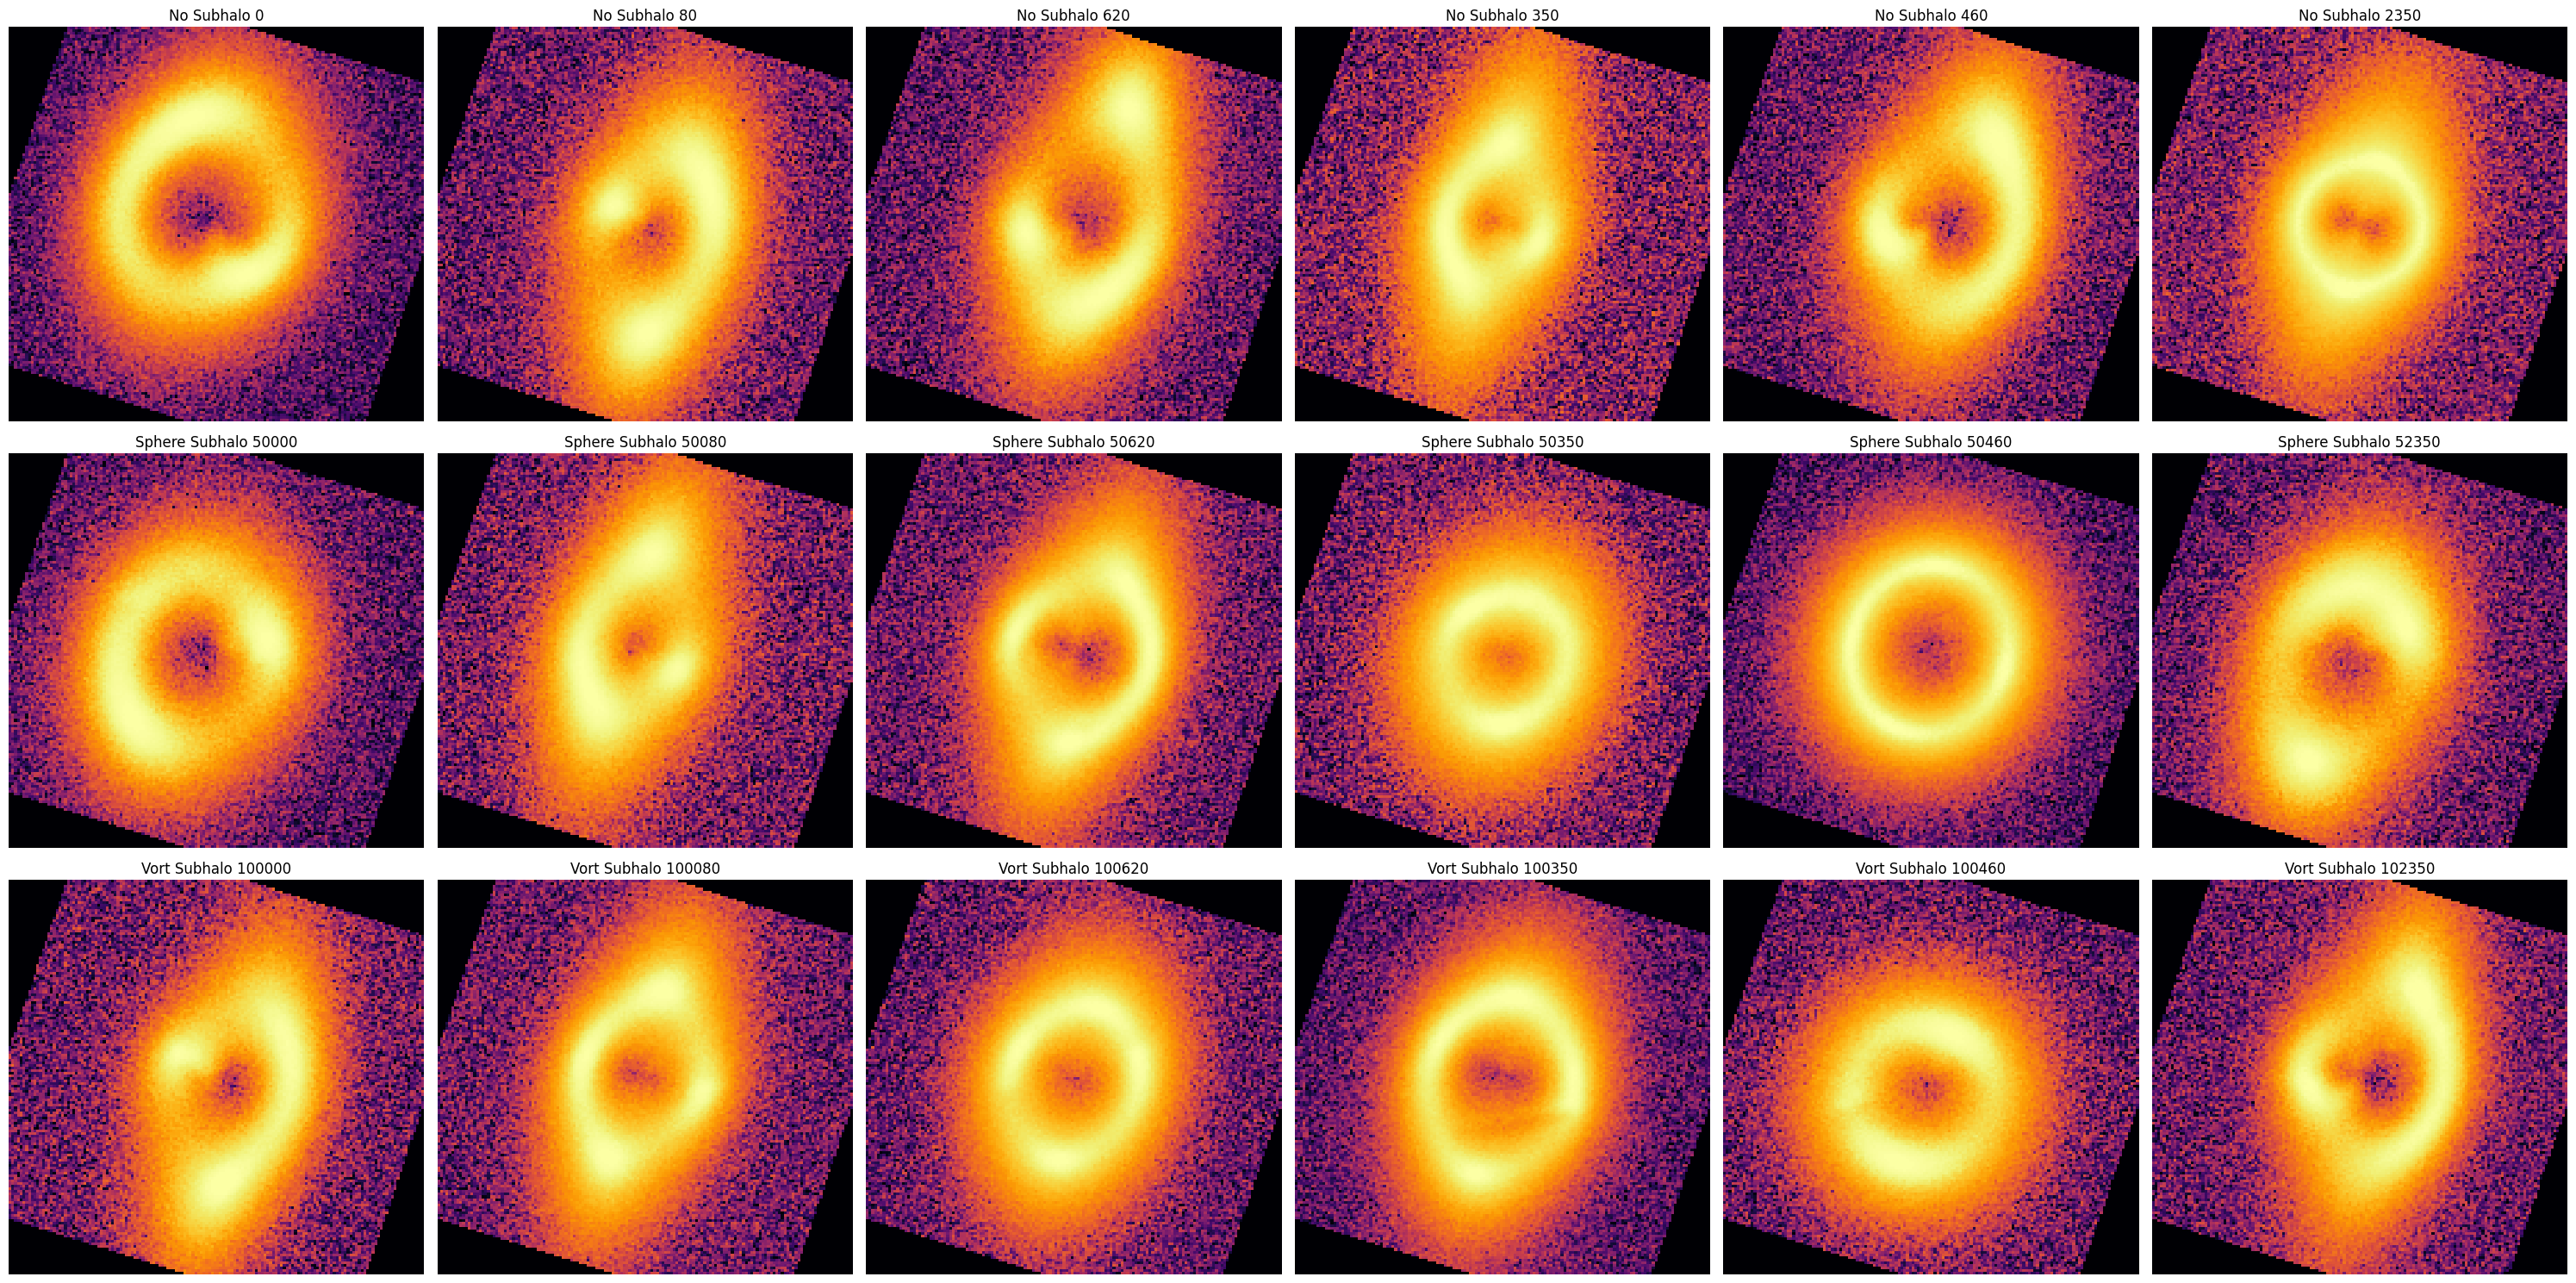

In [84]:
plot_image_grid(x_data, no_subhalo, sphere_subhalo, vort_subhalo, preprocessing_functions=[histogram_normalization()])

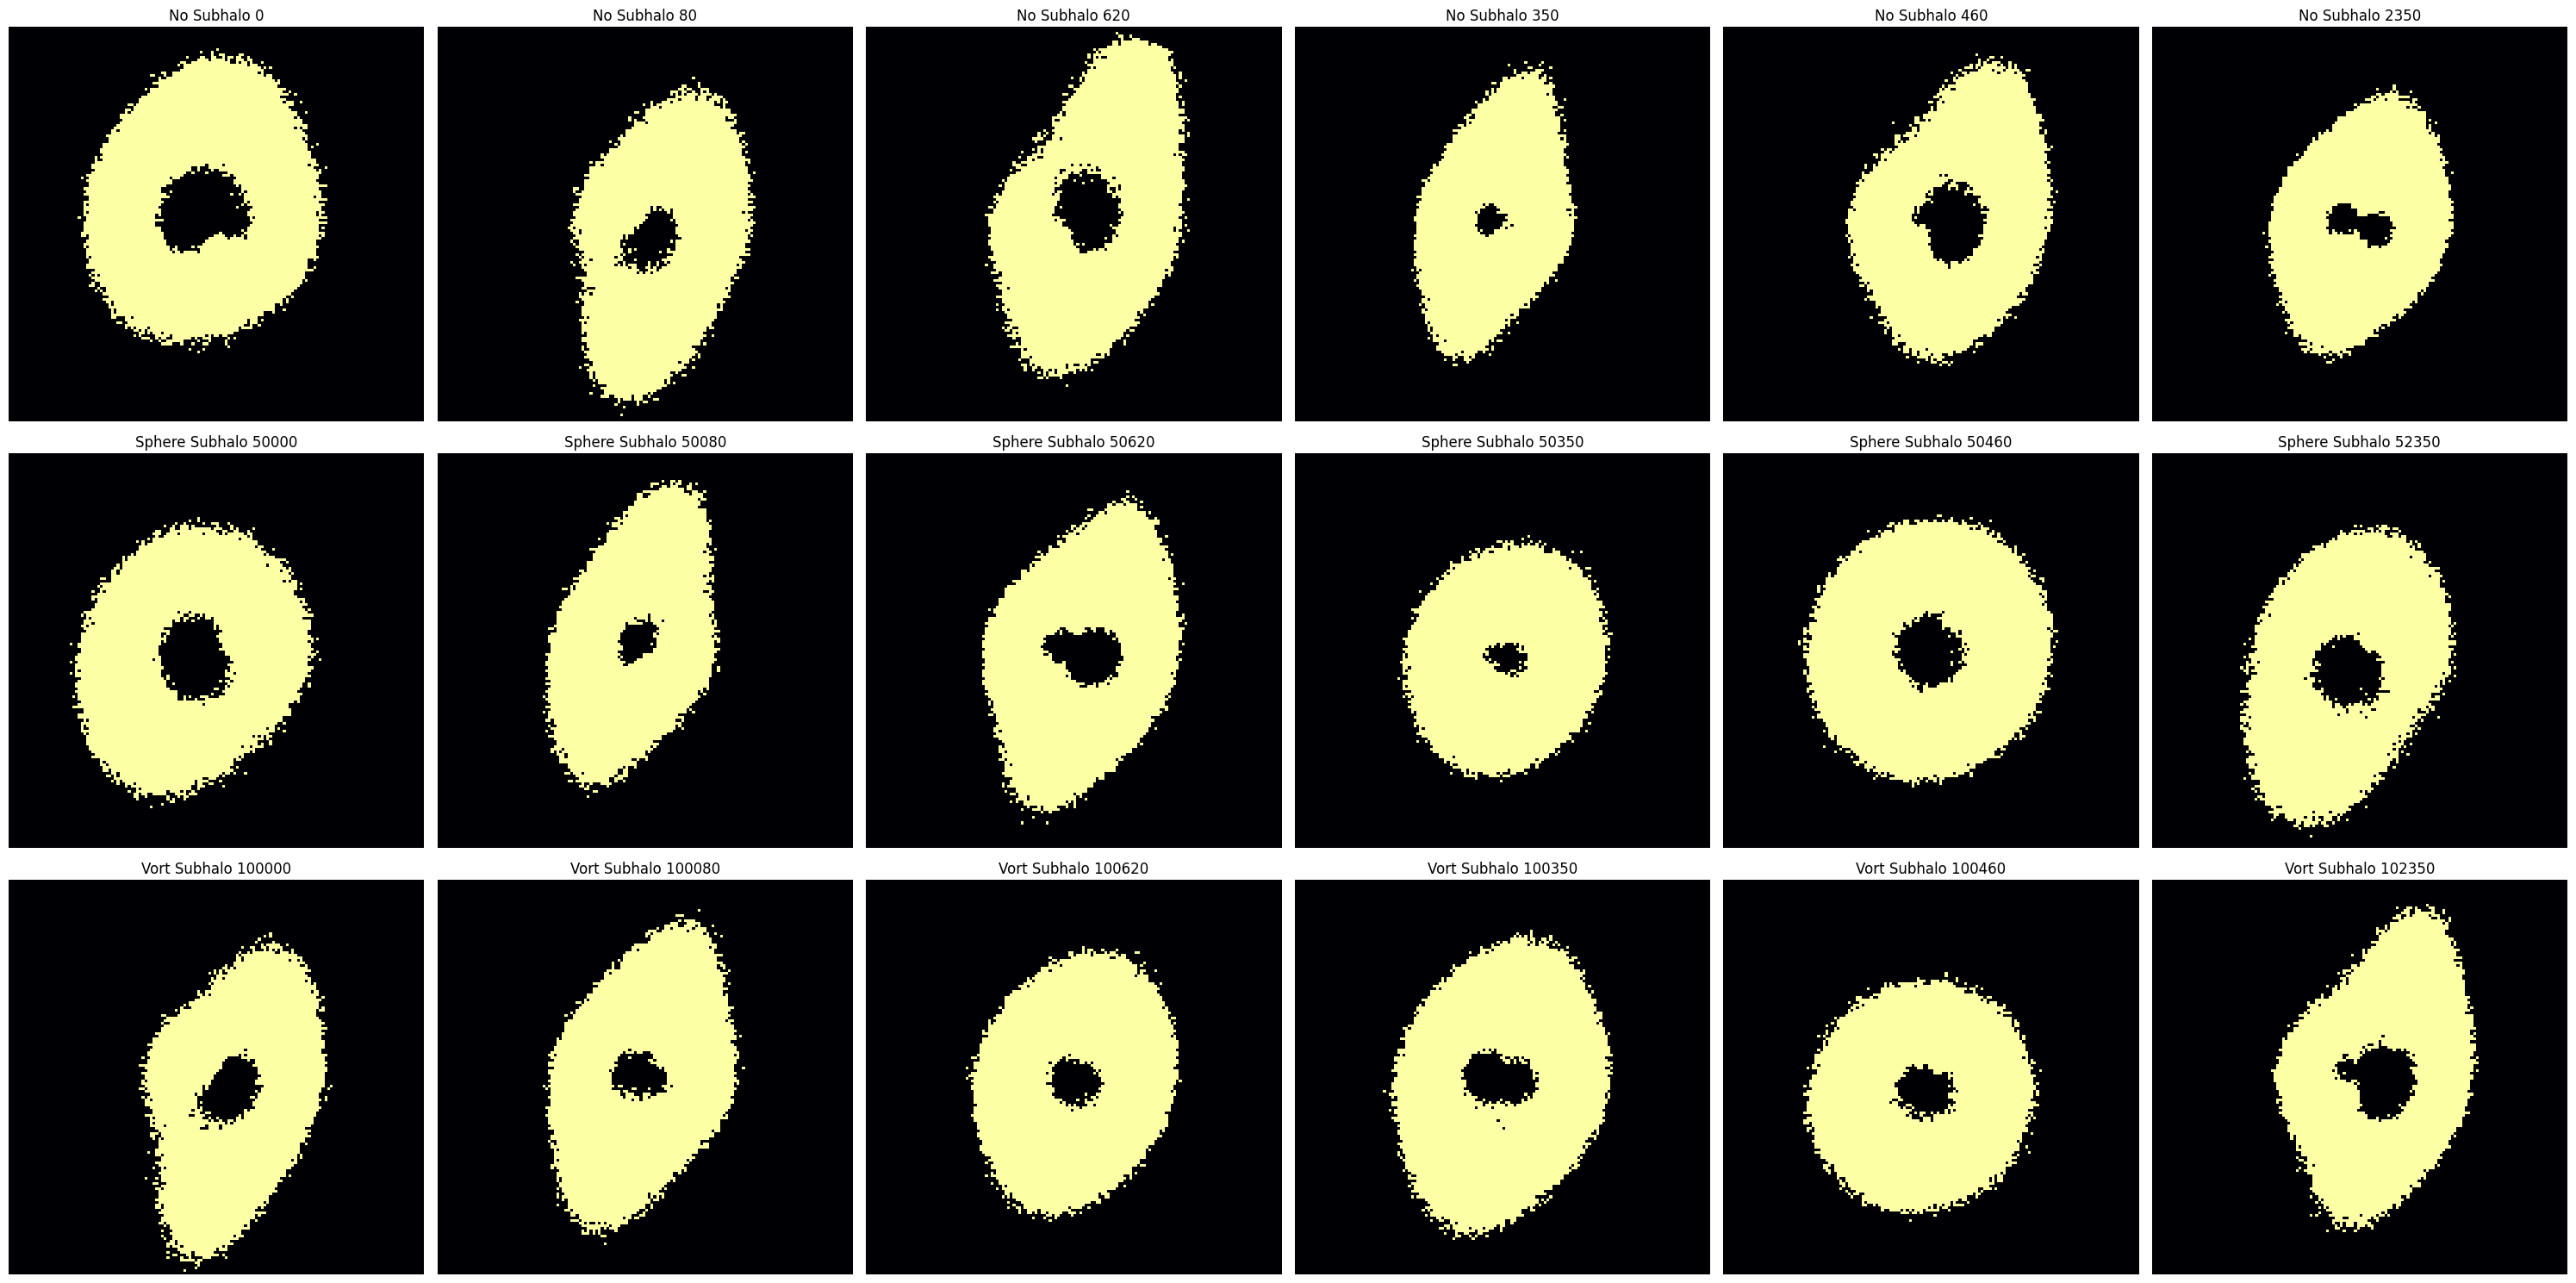

In [85]:
plot_image_grid(x_data, no_subhalo, sphere_subhalo, vort_subhalo, preprocessing_functions=[thresholding(threshold=0.05)])

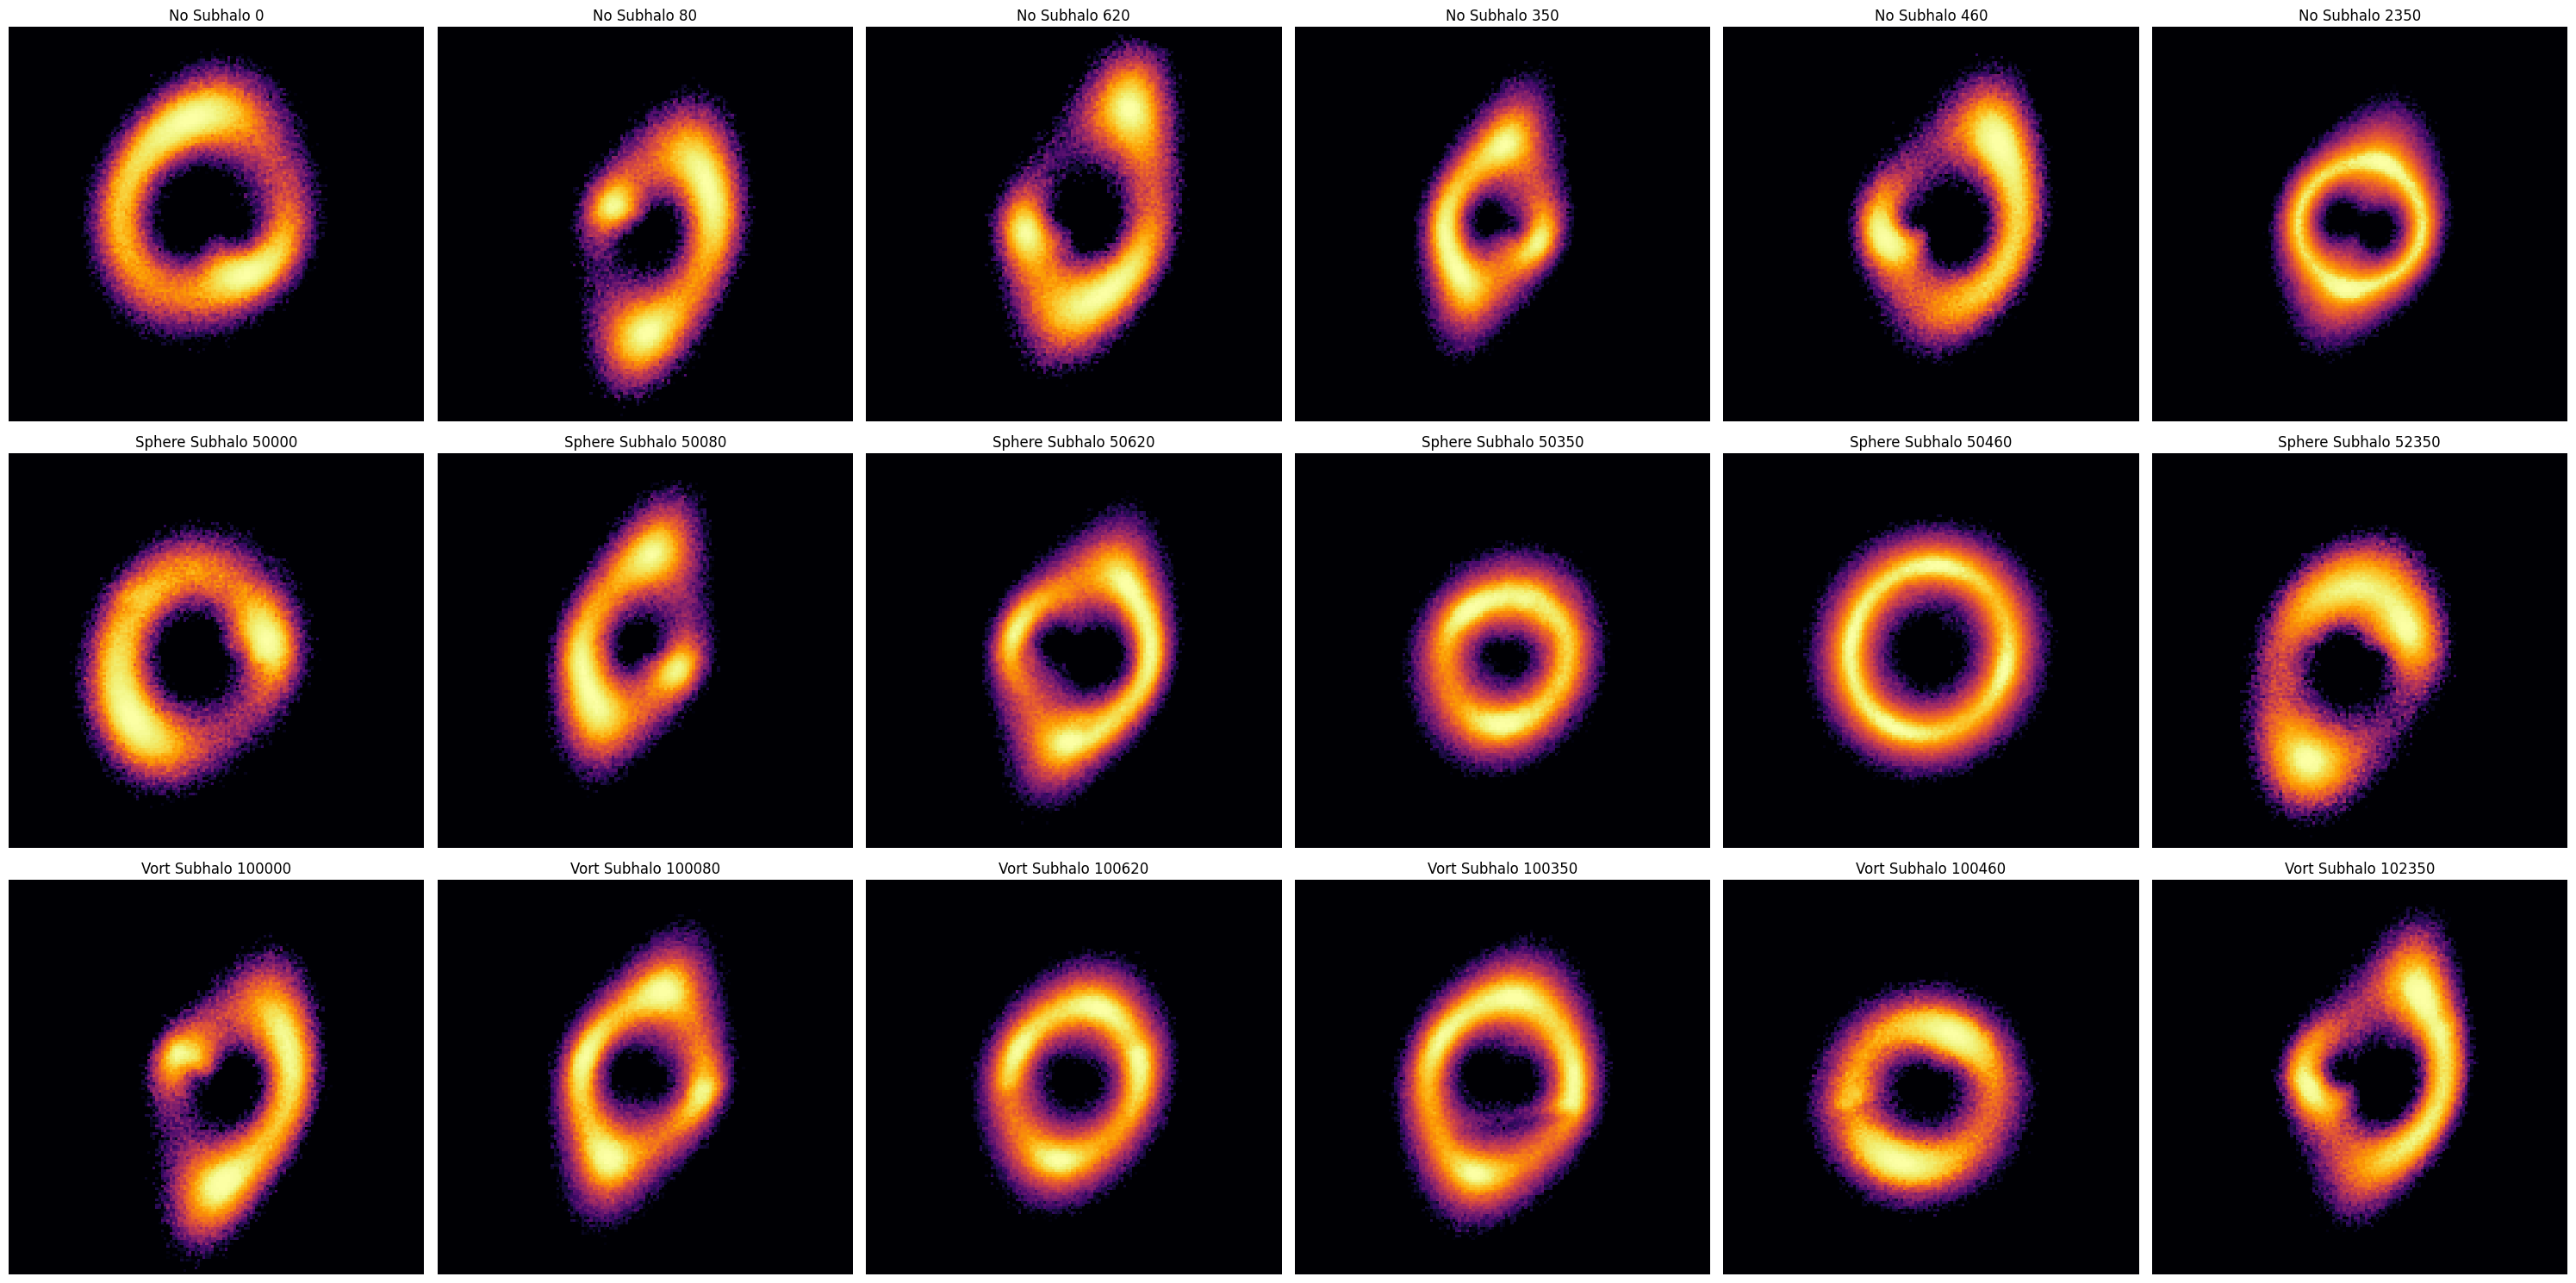

In [86]:
plot_image_grid(x_data, no_subhalo, sphere_subhalo, vort_subhalo, preprocessing_functions=[thresholding_image(threshold=0.05), histogram_normalization()])

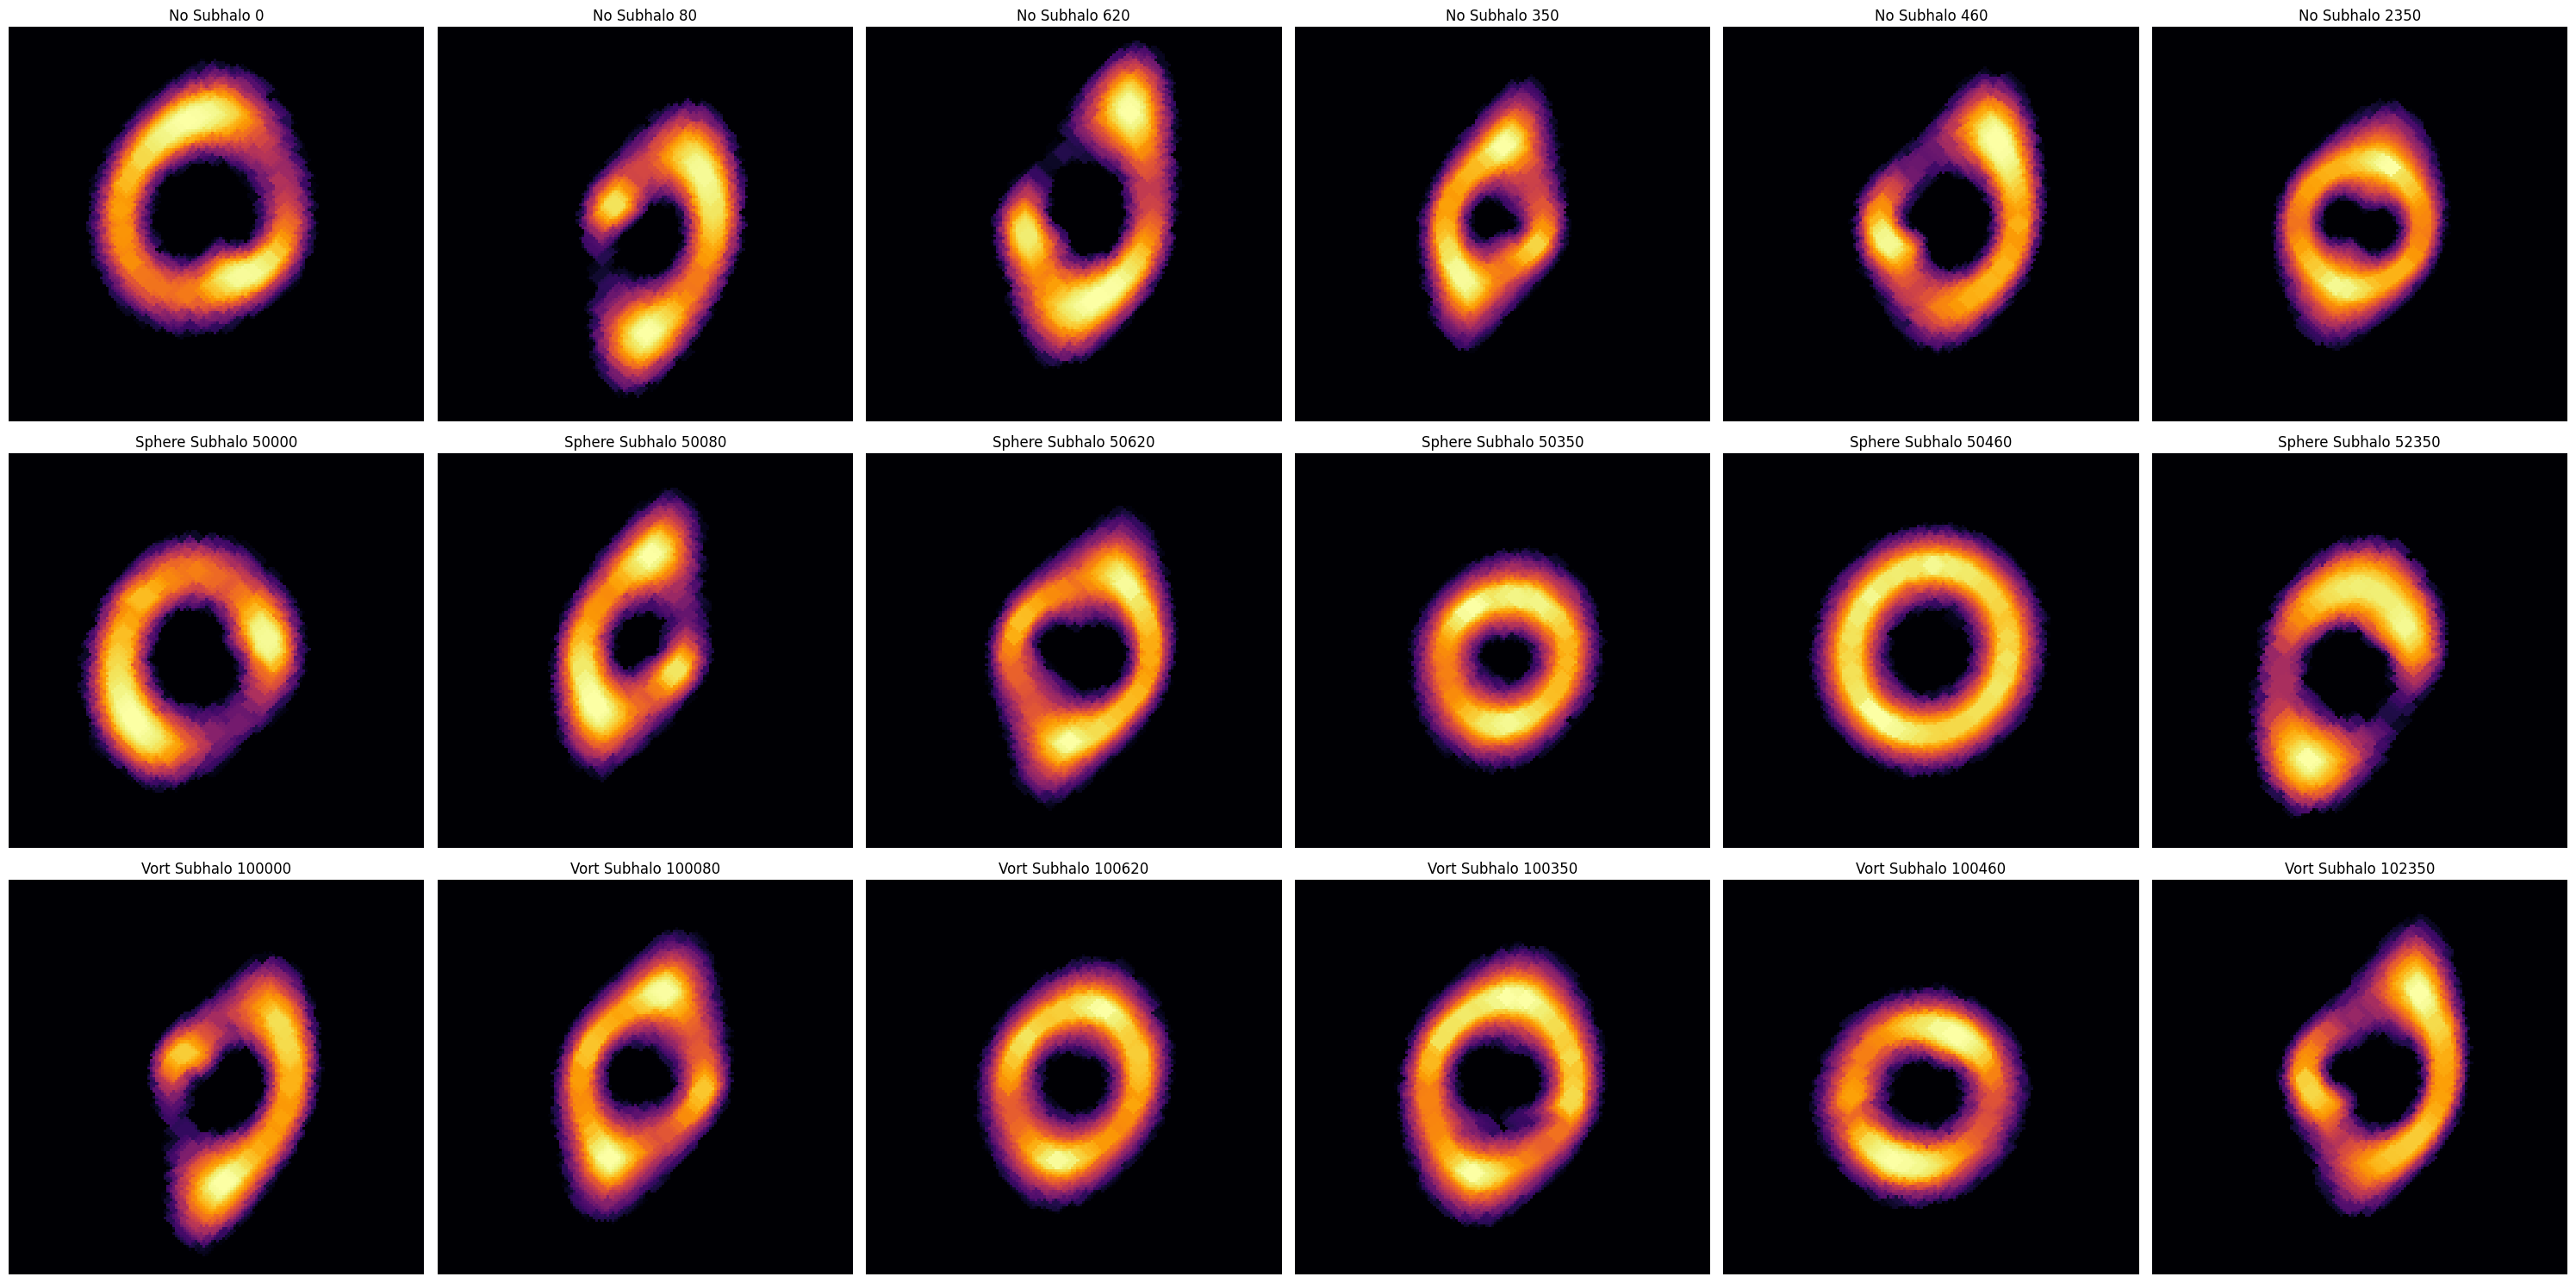

In [87]:
plot_image_grid(x_data, no_subhalo, sphere_subhalo, vort_subhalo, preprocessing_functions=[thresholding_image(threshold=0.05), histogram_normalization(), erosion_dilation(erosion_iter=4, dilation_iter=3)])

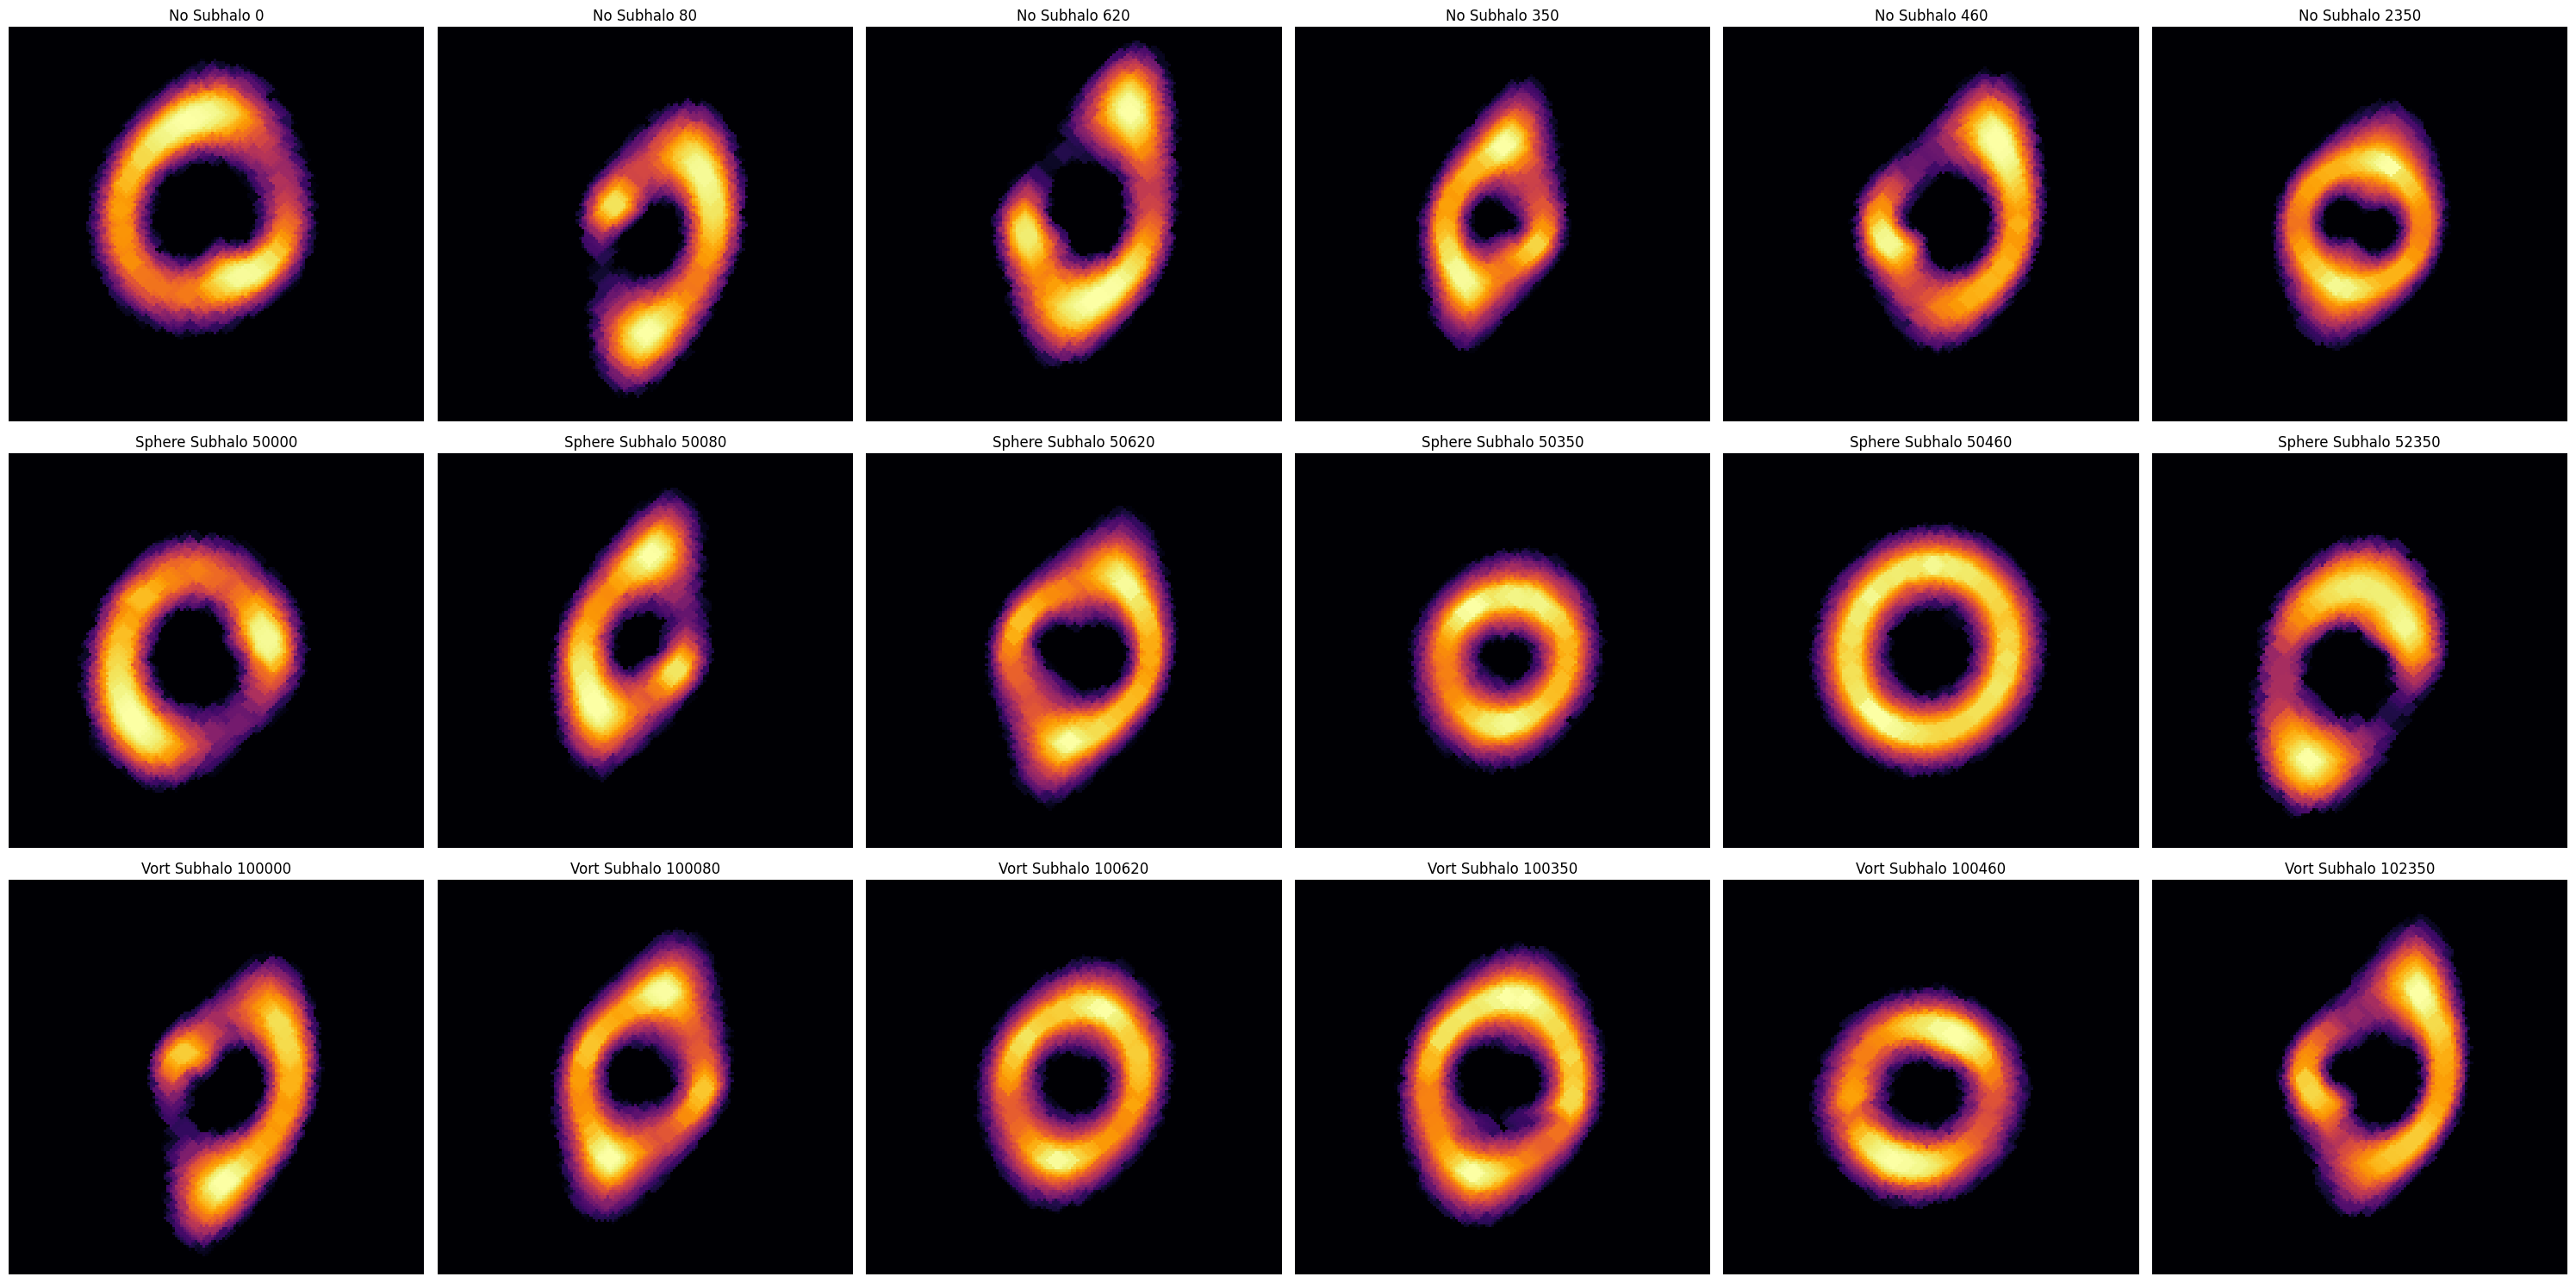

In [88]:
plot_image_grid(x_data, no_subhalo, sphere_subhalo, vort_subhalo, preprocessing_functions=[thresholding_image(threshold=0.05), 
                                                                                           histogram_normalization(), 
                                                                                           erosion_dilation(erosion_iter=4, dilation_iter=3), 
                                                                                            ])

In [89]:

indices_of_prepro = 0
preprocessing_function_to_use = [thresholding_image(threshold=0.05), histogram_normalization(), erosion_dilation(erosion_iter=4, dilation_iter=3)]

no_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[no_subhalo]])
sphere_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[sphere_subhalo]])
vort_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[vort_subhalo]])

np.save(f"../00_data/processed_image_temp/no_subhalo_processed_image{indices_of_prepro}", no_subhalo_processed_image)
np.save(f"../00_data/processed_image_temp/sphere_subhalo_processed_image{indices_of_prepro}", sphere_subhalo_processed_image)
np.save(f"../00_data/processed_image_temp/vort_subhalo_processed_image{indices_of_prepro}", vort_subhalo_processed_image)

In [90]:

indices_of_prepro = 1
preprocessing_function_to_use = [thresholding_image(threshold=0.05), histogram_normalization(), erosion_dilation(erosion_iter=2, dilation_iter=2)]

no_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[no_subhalo]])
sphere_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[sphere_subhalo]])
vort_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[vort_subhalo]])

np.save(f"../00_data/processed_image_temp/no_subhalo_processed_image{indices_of_prepro}", no_subhalo_processed_image)
np.save(f"../00_data/processed_image_temp/sphere_subhalo_processed_image{indices_of_prepro}", sphere_subhalo_processed_image)
np.save(f"../00_data/processed_image_temp/vort_subhalo_processed_image{indices_of_prepro}", vort_subhalo_processed_image)

In [91]:
indices_of_prepro = 2
preprocessing_function_to_use = [thresholding_image(threshold=0.05),  erosion_dilation(erosion_iter=2, dilation_iter=2)]

no_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[no_subhalo]])
sphere_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[sphere_subhalo]])
vort_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[vort_subhalo]])

np.save(f"../00_data/processed_image_temp/no_subhalo_processed_image{indices_of_prepro}", no_subhalo_processed_image)
np.save(f"../00_data/processed_image_temp/sphere_subhalo_processed_image{indices_of_prepro}", sphere_subhalo_processed_image)
np.save(f"../00_data/processed_image_temp/vort_subhalo_processed_image{indices_of_prepro}", vort_subhalo_processed_image)

In [92]:
indices_of_prepro = 3
preprocessing_function_to_use = [thresholding_image(threshold=0.05)]

no_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[no_subhalo]])
sphere_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[sphere_subhalo]])
vort_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[vort_subhalo]])

np.save(f"../00_data/processed_image_temp/no_subhalo_processed_image{indices_of_prepro}", no_subhalo_processed_image)
np.save(f"../00_data/processed_image_temp/sphere_subhalo_processed_image{indices_of_prepro}", sphere_subhalo_processed_image)
np.save(f"../00_data/processed_image_temp/vort_subhalo_processed_image{indices_of_prepro}", vort_subhalo_processed_image)

In [81]:

indices_of_prepro = 4
preprocessing_function_to_use = [thresholding_image(threshold=0.05), histogram_normalization(), normalize_image(),erosion_dilation(erosion_iter=2, dilation_iter=2)]

no_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[no_subhalo]])
sphere_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[sphere_subhalo]])
vort_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[vort_subhalo]])

np.save(f"../00_data/processed_image_temp/no_subhalo_processed_image{indices_of_prepro}", no_subhalo_processed_image)
np.save(f"../00_data/processed_image_temp/sphere_subhalo_processed_image{indices_of_prepro}", sphere_subhalo_processed_image)
np.save(f"../00_data/processed_image_temp/vort_subhalo_processed_image{indices_of_prepro}", vort_subhalo_processed_image)

In [95]:

indices_of_prepro = 4
preprocessing_function_to_use = [thresholding_image(threshold=0.05),  add_minimum_to_image()]

no_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[no_subhalo]])
sphere_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[sphere_subhalo]])
vort_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[vort_subhalo]])

np.save(f"../00_data/processed_image_temp/no_subhalo_processed_image{indices_of_prepro}", no_subhalo_processed_image)
np.save(f"../00_data/processed_image_temp/sphere_subhalo_processed_image{indices_of_prepro}", sphere_subhalo_processed_image)
np.save(f"../00_data/processed_image_temp/vort_subhalo_processed_image{indices_of_prepro}", vort_subhalo_processed_image)

In [96]:

indices_of_prepro = 5
preprocessing_function_to_use = [thresholding_image(threshold=0.05), histogram_normalization(), erosion_dilation(erosion_iter=2, dilation_iter=2), normalize_image(), add_minimum_to_image()]

no_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[no_subhalo]])
sphere_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[sphere_subhalo]])
vort_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[vort_subhalo]])

np.save(f"../00_data/processed_image_temp/no_subhalo_processed_image{indices_of_prepro}", no_subhalo_processed_image)
np.save(f"../00_data/processed_image_temp/sphere_subhalo_processed_image{indices_of_prepro}", sphere_subhalo_processed_image)
np.save(f"../00_data/processed_image_temp/vort_subhalo_processed_image{indices_of_prepro}", vort_subhalo_processed_image)

In [98]:

indices_of_prepro = 6
preprocessing_function_to_use = []

no_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[no_subhalo]])
sphere_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[sphere_subhalo]])
vort_subhalo_processed_image = np.array([ apply_preprocessing(i, preprocessing_function_to_use) for i in x_data[vort_subhalo]])

np.save(f"../00_data/processed_image_temp/no_subhalo_processed_image{indices_of_prepro}", no_subhalo_processed_image)
np.save(f"../00_data/processed_image_temp/sphere_subhalo_processed_image{indices_of_prepro}", sphere_subhalo_processed_image)
np.save(f"../00_data/processed_image_temp/vort_subhalo_processed_image{indices_of_prepro}", vort_subhalo_processed_image)